In [1]:
!pip install tensorflow_addons

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/COLAB_DRIVE/Minimum_Variance_SERS_Net/'
os.chdir(drive_path)
os.getcwd() 
!ls data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ILS_dset_w_labcode.csv	ILS_label_df.csv	 MVBF_Net_Dataset
ILS_feature_df.csv	ILS_label_w_labcode.csv


In [3]:
## Load useful packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, ConvLSTM1D, Add
from tensorflow.keras.optimizers import *
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization

In [4]:
def extract_train_test_data(ILS_DATA, ILS_LABEL, test_lab_index):
  # test_lab_index = 0
  valid_lab_index = np.random.choice(4,1)
  lab_IDs=ILS_DATA.iloc[:,0].unique()
  num_labs = lab_IDs.shape[0]

  test_lab_ID =lab_IDs[test_lab_index]
  remain_labs = np.squeeze(lab_IDs[np.argwhere(np.asarray(lab_IDs)!=test_lab_ID)])
  valid_lab_ID = remain_labs[valid_lab_index]
  train_lab_IDs = np.squeeze(remain_labs[np.argwhere(np.asarray(remain_labs)!=valid_lab_ID)])

  test_indices = np.squeeze(np.argwhere(np.asarray(ILS_DATA.iloc[:,0])==test_lab_ID))
  valid_indices = np.squeeze(np.argwhere(np.asarray(ILS_DATA.iloc[:,0])==valid_lab_ID))
  train_indices = np.squeeze(np.argwhere((np.asarray(ILS_DATA.iloc[:,0])!=valid_lab_ID)&(np.asarray(ILS_DATA.iloc[:,0])!=test_lab_ID)))

  train_data = ILS_DATA.iloc[train_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  train_label = ILS_LABEL.iloc[train_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  train_X_LabConVec = ILS_DATA.iloc[train_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level
  train_Y_LabConVec = ILS_LABEL.iloc[train_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level
  
  valid_data = ILS_DATA.iloc[valid_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  valid_label = ILS_LABEL.iloc[valid_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  valid_X_LabConVec = ILS_DATA.iloc[valid_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level
  valid_Y_LabConVec = ILS_LABEL.iloc[valid_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level

  test_data = ILS_DATA.iloc[test_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  test_label = ILS_LABEL.iloc[test_indices,2:] # skip 1&2 because 1st is labID, 2nd is concentration level
  test_X_LabConVec = ILS_DATA.iloc[test_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level
  test_Y_LabConVec = ILS_LABEL.iloc[test_indices,0:2] # skip 1&2 because 1st is labID, 2nd is concentration level

  print('Number of Labs = ', num_labs)
  print('Test-lab ID:',test_lab_ID,
        '\nValidation-lab IDs: ',valid_lab_ID,
        '\nTraining-lab IDs: ',train_lab_IDs)
  print('Number of X(samples, attributes) | \t Y(samples, attributes) in test-set =',test_data.shape,test_label.shape,
        '\nNumber of X(samples, attributes) | \t Y(samples, attributes) in validation-set =', valid_data.shape,valid_label.shape,
        '\nNumber of X(samples, attributes) | \t Y(samples, attributes) in training-set =', train_data.shape,train_label.shape)
  return train_data, valid_data, test_data, train_label, valid_label, test_label, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec

In [5]:
ILS_feature_dt = pd.read_csv('./data/ILS_dset_w_labcode.csv')
ILS_label_dt = pd.read_csv('./data/ILS_label_w_labcode.csv')

print('Checking uniqueness of Input and Label data')
Num_entr = np.unique(np.mean(np.asarray(ILS_feature_dt.iloc[:,2:]),axis=1)).shape[0]
Num_conc = np.unique(np.mean(np.asarray(ILS_label_dt.iloc[:,2:]),axis=1)).shape[0]
print('Number of unique measurement entries: ', Num_entr)
print('Number of unique concentrations: ', Num_conc)

Checking uniqueness of Input and Label data
Number of unique measurement entries:  675
Number of unique concentrations:  15


In [6]:
def load_lab_data(test_lab_index):
  [train_dset, valid_dset, test_dset, train_label, valid_label, test_label, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec] = extract_train_test_data(ILS_feature_dt, ILS_label_dt, test_lab_index)
  # [train_label, valid_label, test_label, train_lab_IDs, valid_lab_ID, test_lab_ID] = extract_train_test_data(ILS_label_dt,test_lab_index)
  # [train_dset, test_dset, lab_ID] = extract_train_test_data(ILS_feature_dt,test_lab_index)
  # [train_label, test_label, lab_ID] = extract_train_test_data(ILS_label_dt,test_lab_index)

  ############################################ --- DIMENSION EXPANSION --- ############################################
  print(20*'--')
  print('train_data_min:\t\t%3.3f\ntrain_data_max:\t\t%3.3f' % (np.min(np.min(train_dset)),np.max(np.max(train_dset))))
  print('train_label_min:\t%3.3f\ntrain_label_max:\t%3.3f' % (np.min(np.min(train_label)),np.max(np.max(train_label))))
  print('valid_data_min:\t\t%3.3f\nvalid_data_max:\t\t%3.3f' % (np.min(np.min(valid_dset)),np.max(np.max(valid_dset))))
  print('valid_label_min:\t%3.3f\nvalid_label_max:\t%3.3f' % (np.min(np.min(valid_label)),np.max(np.max(valid_label))))
  print('train_data_min:\t\t%3.3f\ntrain_data_max:\t\t%3.3f' % (np.min(np.min(test_dset)),np.max(np.max(test_dset))))
  print('train_label_min:\t%3.3f\ntrain_label_max:\t%3.3f' % (np.min(np.min(test_label)),np.max(np.max(test_label))))

  ############################################ --- NORMALIZATION (SCALING) --- ############################################
  train_dset = train_dset.divide(train_dset.max(axis=1), axis='rows')
  train_label = train_label.divide(train_label.max(axis=1), axis='rows')
  valid_dset = valid_dset.divide(valid_dset.max(axis=1), axis='rows')
  valid_label = valid_label.divide(valid_label.max(axis=1), axis='rows')
  test_dset = test_dset.divide(test_dset.max(axis=1), axis='rows')
  test_label = test_label.divide(test_label.max(axis=1), axis='rows')

  print(20*'--')
  print('train_data_min:\t\t%3.3f\ntrain_data_max:\t\t%3.3f' % (np.min(np.min(train_dset)),np.max(np.max(train_dset))))
  print('train_label_min:\t%3.3f\ntrain_label_max:\t%3.3f' % (np.min(np.min(train_label)),np.max(np.max(train_label))))
  print('valid_data_min:\t\t%3.3f\nvalid_data_max:\t\t%3.3f' % (np.min(np.min(valid_dset)),np.max(np.max(valid_dset))))
  print('valid_label_min:\t%3.3f\nvalid_label_max:\t%3.3f' % (np.min(np.min(valid_label)),np.max(np.max(valid_label))))
  print('train_data_min:\t\t%3.3f\ntrain_data_max:\t\t%3.3f' % (np.min(np.min(test_dset)),np.max(np.max(test_dset))))
  print('train_label_min:\t%3.3f\ntrain_label_max:\t%3.3f' % (np.min(np.min(test_label)),np.max(np.max(test_label))))

  [X_train, y_train] = np.asarray(train_dset), np.asarray(train_label)
  [X_val, y_val] = np.asarray(valid_dset), np.asarray(valid_label)
  [X_test, y_test] = np.asarray(test_dset), np.asarray(test_label)

  print('X_train_shape:\t\t%s' %str(X_train.shape))
  print('X_val_shape:\t\t%s' %str(X_val.shape))
  print('X_test_shape:\t\t%s' %str(X_test.shape))
  # print('X_ind_test_shape:\t%s' %str(X_ind_test.shape))

  print('y_train_shape:\t\t%s' %str(y_train.shape))
  print('y_val_shape:\t\t%s' %str(y_val.shape))
  print('y_test_shape:\t\t%s' %str(y_test.shape))
  # print('y_ind_test_shape:\t%s' %str(y_ind_test.shape))

  return X_train, X_val, X_test, y_train, y_val, y_test, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec

In [7]:
## Designing an Auto-Encoder-Classifier model
def MV_Net(input_shape=(534,1)):
    # Encoder Network
    enc_input = Input(shape=(input_shape[0]), name='enc_input')
    enc_l1 = Dense(input_shape[0], activation='relu', name='encoder_layer1')(enc_input)
    enc_l1 = BatchNormalization()(enc_l1)
    enc_l1 = Add()([enc_l1,enc_input])

    decoder_output = Dense(input_shape[0], activation='sigmoid', name='decoder_output')(enc_l1)
    
    model = Model(inputs=[enc_input], outputs=[decoder_output, decoder_output])

    # Compiling model
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss={'decoder_output': 'mean_squared_error', 'decoder_output': 'mean_squared_error'},
                  loss_weights={'decoder_output': 0.5, 'decoder_output': 0.5},
                  # loss_weights={'decoder_output': 0.01, 'decoder_output': 0.99},
                  # loss_weights={'decoder_output': 0.99, 'decoder_output': 0.01},                  
                  metrics=[metrics.mean_squared_error])
    return model

model = MV_Net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 534)]        0           []                               
                                                                                                  
 encoder_layer1 (Dense)         (None, 534)          285690      ['enc_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 534)         2136        ['encoder_layer1[0][0]']         
 alization)                                                                                       
                                                                                                  
 add (Add)                      (None, 534)          0           ['batch_normalization[0][0]',

In [8]:
def plot_PCA_prof(X_ind_test,y_ind_test,y_ind_test_pred,test_lab_ID):
  pca = PCA(n_components=2, whiten='True')
  pca.fit(X_ind_test.squeeze())
  X_ind_test_PCA = pca.transform(X_ind_test.squeeze())
  y_ind_test_PCA = pca.transform(y_ind_test.squeeze())
  y_ind_test_pred_PCA = pca.transform(y_ind_test_pred.squeeze())
  plt.figure(test_lab_index, figsize = (14,12)) # '#2ca02c'

  ##############################################
  plt.figure(test_lab_index, figsize = (14,12)) # '#2ca02c'
  leg_text = []

  NS = X_ind_test.shape[0] # number of test samples
  NC = Num_conc # number of concentrations
  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(X_ind_test_PCA[range(0 + i*9,9*(i+1)),0], X_ind_test_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'green', s =100+100*i/NC)
    leg_text.append('Input-C'+str(i))

  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(y_ind_test_PCA[range(0 + i*9,9*(i+1)),0], y_ind_test_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'red', s = 100+100*i/NC)
    leg_text.append('Target-C'+str(i))

  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(y_ind_test_pred_PCA[range(0 + i*9,9*(i+1)),0], y_ind_test_pred_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'blue', s = 100+100*i/NC)
    leg_text.append('Output-C'+str(i))

  plt.title(test_lab_ID+'PCA_em for Input, Label, and Ouput data (fit->INPUT, transform -> ALL) Model: 1D-Conv')
  plt.legend(leg_text)

Number of Labs =  5
Test-lab ID: P01 
Validation-lab IDs:  ['P13'] 
Training-lab IDs:  ['P04' 'P08' 'P18']
Number of X(samples, attributes) | 	 Y(samples, attributes) in test-set = (135, 534) (135, 534) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in validation-set = (135, 534) (135, 534) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in training-set = (405, 534) (405, 534)
----------------------------------------
train_data_min:		363.000
train_data_max:		408342.000
train_label_min:	3529.489
train_label_max:	106296.000
valid_data_min:		270.000
valid_data_max:		62272.000
valid_label_min:	3529.489
valid_label_max:	106296.000
train_data_min:		1135.000
train_data_max:		108701.000
train_label_min:	3529.489
train_label_max:	106296.000
----------------------------------------
train_data_min:		0.042
train_data_max:		1.000
train_label_min:	0.107
train_label_max:	1.000
valid_data_min:		0.035
valid_data_max:		1.000
valid_label_min:	0.107
valid_label_max:	1.000
train_

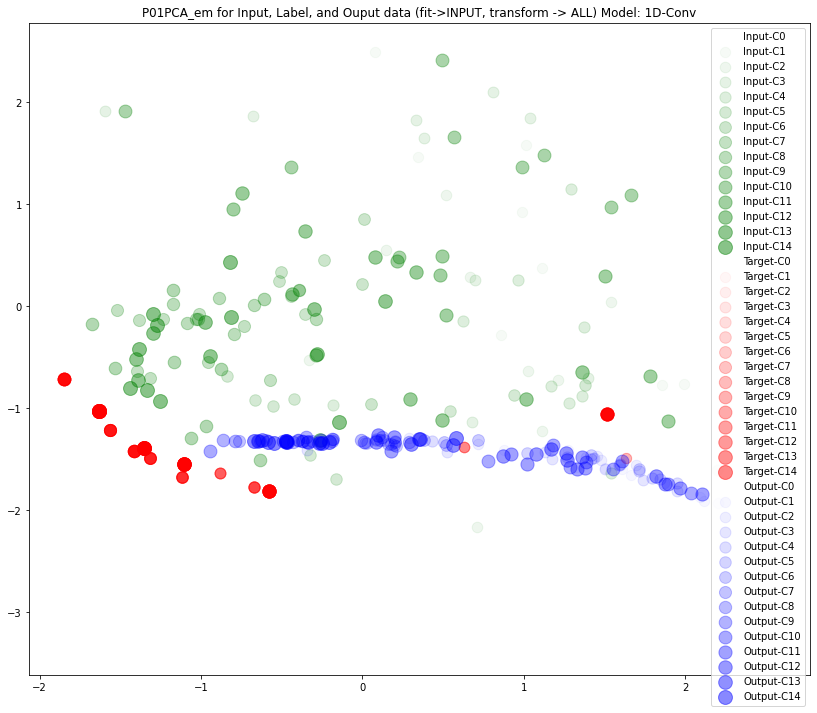

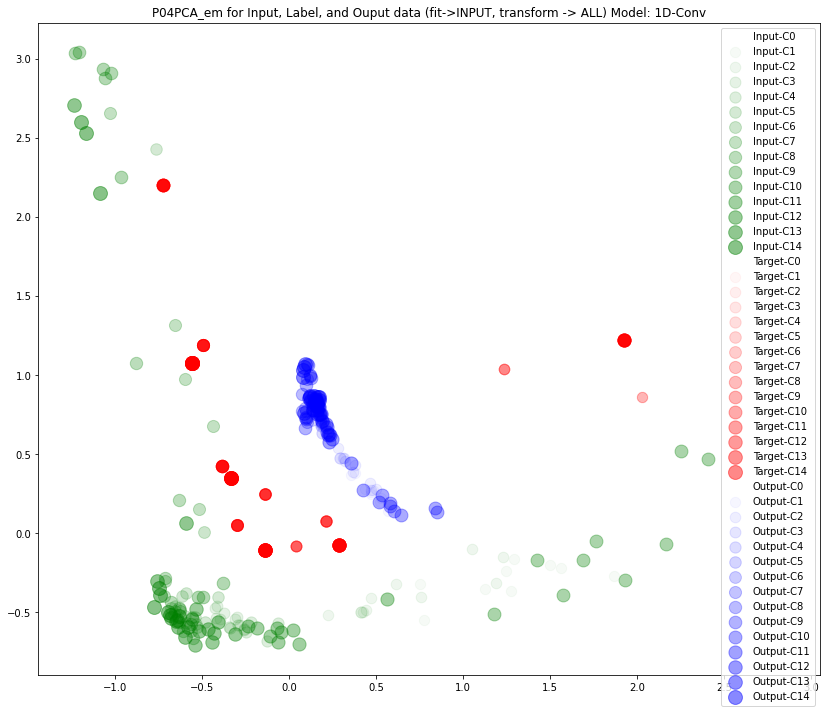

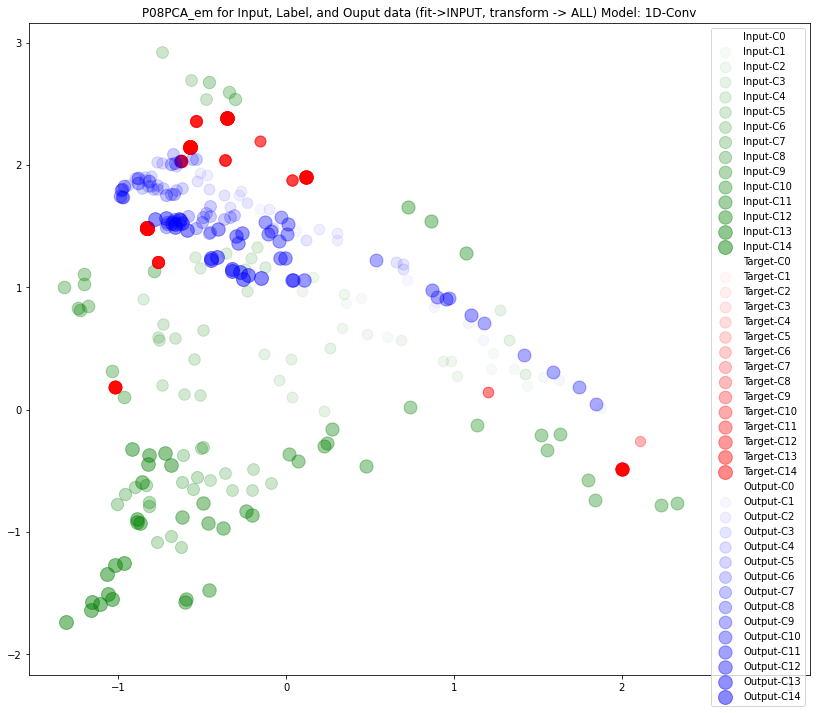

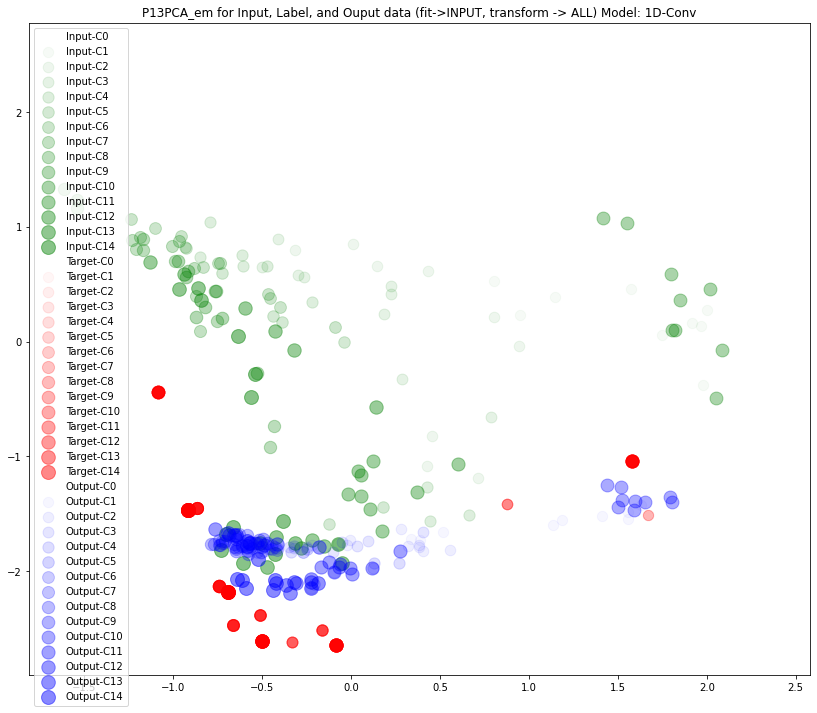

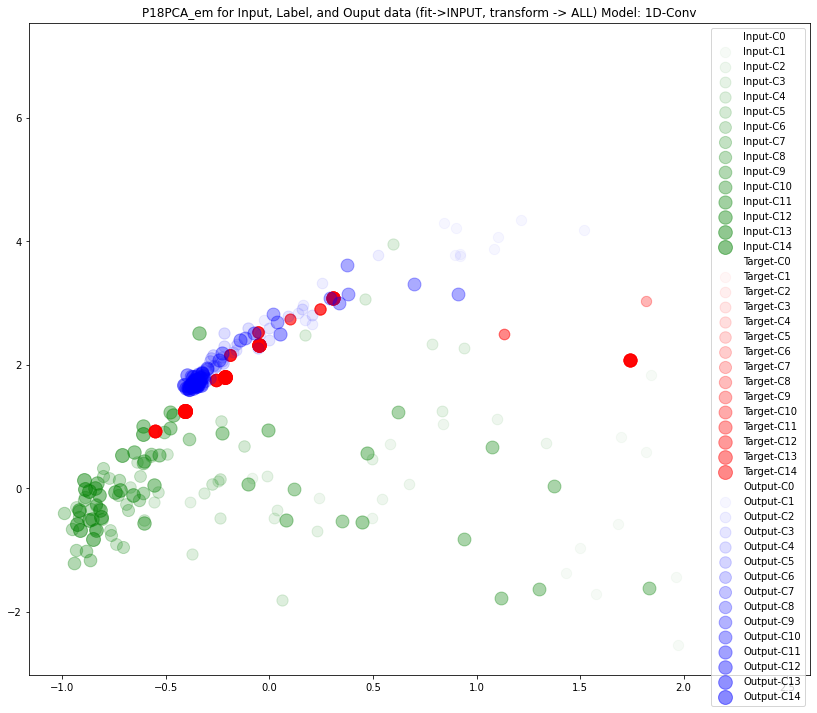

In [9]:
from scipy.io import savemat
for test_lab_index in range(0,5):
  Stats=[]
  X_train, X_valid, X_ind_test, y_train, y_valid, y_ind_test, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec = load_lab_data(test_lab_index)

  model = MV_Net()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
  # es = EarlyStopping(monitor='val_class_output_categorical_accuracy', mode='max', verbose=0, patience=100)
  if not os.path.exists("models"):
    os.mkdir("models")
      
  checkpoint = ModelCheckpoint("./models/model-best.h5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')
      
  history = model.fit({'enc_input': X_train}, {'decoder_output': X_train, 'decoder_output': y_train},
                      validation_data = ({'enc_input': X_valid}, {'decoder_output': X_valid, 'decoder_output': y_valid}),
                      epochs=5000, batch_size=405, callbacks=[checkpoint, es], verbose=0)

  # history = model.fit(X_train, y_train,
  #                     validation_data = (X_val,y_val),
  #                     epochs=10000, batch_size=450, callbacks=[checkpoint, es], verbose=0)

  del model  # deletes the existing model
  model = load_model("./models/model-best.h5")

  [temp, y_train_pred] = model.predict(X_train, batch_size=405, verbose=0)
  MSE_y_train_pred = (np.square(y_train_pred - y_train)).mean(axis=1)

  [temp, y_valid_pred] = model.predict(X_valid, batch_size=405, verbose=0)
  MSE_y_val_pred = (np.square(y_valid_pred - y_valid)).mean(axis=1)

  # [temp, y_test_pred] = model.predict(X_test, batch_size=450, verbose=0)
  # MSE_y_test_pred = (np.square(y_test_pred - y_test)).mean(axis=1)

  [temp, y_ind_test_pred] = model.predict(X_ind_test, batch_size=405, verbose=0)
  MSE_y_ind_test_pred = (np.square(y_ind_test_pred - y_ind_test)).mean(axis=1)

  Stats.append([-10*np.log10(MSE_y_train_pred.mean()), -10*np.log10(MSE_y_val_pred.mean()), -10*np.log10(MSE_y_ind_test_pred.mean())])
  print('MSE_y_train_pred:', -10*np.log10(MSE_y_train_pred.mean()),
        'MSE_y_valid_pred:', -10*np.log10(MSE_y_val_pred.mean()),
        'MSE_y_ind_test_pred:', -10*np.log10(MSE_y_ind_test_pred.mean()))

  Statistics = np.asarray(Stats)
  plot_PCA_prof(X_ind_test,y_ind_test,y_ind_test_pred,test_lab_ID)

  save_dir = 'LOLO_CV_RESULTS'
  if (not(os.path.isdir(save_dir))):
    os.mkdir(save_dir)
    print('CREATING NEW DIRECTORY')
  else:
    print('SAVE DIRECTORY ALREADY EXIST')

  filename = save_dir + '/LOLO_CV_RESULTS_LAB_ID_' + test_lab_ID + '.mat'
  savemat(filename,{'X_train':X_train,'y_train':y_train,'y_train_pred':y_train_pred,
                    'X_valid':X_valid,'y_valid':y_valid,'y_valid_pred':y_valid_pred,
                    'X_ind_test':X_ind_test,'y_ind_test':y_ind_test,'y_ind_test_pred':y_ind_test_pred,
                    'train_lab_IDs':train_lab_IDs,'valid_lab_ID':valid_lab_ID, 'test_lab_ID':test_lab_ID,
                    'train_X_LabConVec':np.asarray(train_X_LabConVec), 'train_Y_LabConVec':np.asarray(train_Y_LabConVec), 'valid_X_LabConVec':np.asarray(valid_X_LabConVec),
                    'valid_Y_LabConVec':np.asarray(valid_Y_LabConVec), 'test_X_LabConVec':np.asarray(test_X_LabConVec), 'test_Y_LabConVec':np.asarray(test_Y_LabConVec)})
  
  # print(test_Y_LabConVec)

  print('SAVING... '+ filename)
  del model  # deletes the existing model

